# **Assignment 3: Milestone I | Natural Language Processing**
## **Task 1. Basic Text Pre-processing**

**Group 01:**
- Tran Tu Tam (s3999159)
- Phan Nhat Minh (s3978598)
- Le Thien Son (s3977955)

**Environment**: 

To ensure full reproducibility, the Python environment used in this assignment is managed with **conda**. We worked with **Python 3.10** on **conda 25.7.0** inside Jupyter Notebook.  

The exact environment can be recreated by running the following command with the provided `environment.yaml` file:

```bash
conda env create -f environment.yaml
```

After creating the environment, activate it with:

```bash
conda activate ap4ds-a3
```

**Libraries used**: 
* `pandas` – data handling and manipulation
* `re` – regular expressions for tokenization
* `collections.Counter` – frequency counting
* `nltk` – natural language processing tools (including stemmers and lemmatizers)
* `matplotlib` – data visualization
* `spellchecker` – typo detection and correction

## Introduction  

Online clothing retailers increasingly rely on customer reviews to guide product recommendations and improve shopping experiences.  
These reviews, however, are unstructured text and often contain inconsistencies such as stopwords, misspellings, or overly frequent and rare terms.  

In this notebook, we address the problem of preparing raw review text for machine learning tasks.  
Following the assignment requirements, we:  
- Clean and preprocess the text using tokenization, lowercasing, and filtering steps.  
- Apply lemmatization to standardize word forms.  
- Fix common misspellings with a spellchecker enhanced by whitelists and manual corrections.  
- Check for and remove null or empty reviews created during preprocessing.  
- Save the cleaned dataset and its vocabulary for later use in feature representation and classification models.  

This pipeline ensures that the reviews are transformed into a structured, high-quality dataset suitable for downstream NLP tasks.  

## 1. Importing Libraries  

We begin by importing the necessary libraries for this task:  
- **pandas, re, Counter** for data handling and text processing utilities.  
- **nltk, PorterStemmer, WordNetLemmatizer, SpellChecker** for natural language preprocessing, lemmatization, and typo correction.  
- **matplotlib** for visualizing distributions and exploratory results.  

In [217]:
# Data handling and utilities
import pandas as pd
import re
from collections import Counter

# NLP preprocessing
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from spellchecker import SpellChecker

# Visualization
import matplotlib.pyplot as plt

## 2. Loading and Examining the Data

### 2.1 Loading the Data
To begin our analysis, we first load the dataset that will serve as the foundation of this assignment. This dataset contains thousands of customer reviews on clothing items, which we will later process and transform into features for model building. Alongside it, we also bring in the stop words dictionary, which will help us filter out common words that do not contribute much meaning to the analysis.

In [ ]:
# Define file paths
data_path = "../data/assignment3.csv"
stopwords_path = "../data/stopwords_en.txt"

# Load dataset and stopwords
try:
    # Load the clothing reviews dataset
    df = pd.read_csv(data_path)
    
    # Load stopwords into a set for fast lookup
    with open(stopwords_path, "r", encoding="utf-8") as f:
        stopwords = {line.strip().lower() for line in f if line.strip()}
    
    print("Dataset and stopwords successfully loaded.")
    
except FileNotFoundError as e:
    # Display message if the file paths are incorrect
    print(f"File not found: {e}. Please check the file paths.")

Dataset and stopwords successfully loaded.


Now, let’s explore the dataset to get a quick sense of its structure and contents.

In [219]:
df.shape

(19662, 10)

In [220]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits


Through the `df.shape` and `df.head()`, we can see that:

- The dataset has 19,662 rows and 10 columns, meaning we are working with a fairly large collection of reviews.
- Each row corresponds to a customer review of a clothing item.
- Key columns include:
    - `Clothing ID` – identifier for the product.
    - `Age` – reviewer’s age.
    - `Title` and `Review Text` – short and detailed parts of the review.
    - `Rating` – customer’s rating score.
    - `Recommended IND` – target label indicating whether the customer recommended the item (1 = yes, 0 = no).
    - `Positive Feedback Count` – how many users found the review helpful.
    - `Division/Department/Class Name` – product category information.

This quick check confirms that the dataset contains both textual data (reviews, titles) and structured attributes (ratings, categories), which will be useful for analysis and modeling later.

Lastly, we want to double check if the stopwords list imported corrrectly.

In [221]:
print(list(stopwords)[:10])  # Display first 10 stopwords to verify loading

['course', 'it', 'less', 'can', 'could', 'welcome', 'said', 'another', 'think', 'himself']


### 2.2 Data Exploration

Before moving into the defined preprocessing steps, it is useful to run a few quick checks on the dataset. This helps us spot potential issues such as missing values, unusual characters, very short reviews, or class imbalance, and gives us a better understanding of the raw text we are working with.

#### 2.2.1  Missing Values

As a first step in the preprocessing stage, we examine the dataset for any missing or null values. This helps us identify potential data quality issues before moving on to further cleaning and analysis.

In [222]:
df.isnull().sum()

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64

We can see that the data does not contain any null values.

#### 2.2.2 Distribution of Review Lengths

Next, we analyze the distribution of review lengths to understand how detailed the customer feedback is. This step is important because very short reviews may lack useful information, while extremely long ones could introduce noise. By checking the distribution, we can identify outliers and decide whether any filtering or adjustments are needed before feature extraction.

In [223]:
df["review_length"] = df["Review Text"].astype(str).apply(lambda x: len(x.split()))
df["review_length"].describe()

count    19662.000000
mean        62.115146
std         28.200497
min          2.000000
25%         38.000000
50%         62.000000
75%         90.000000
max        115.000000
Name: review_length, dtype: float64

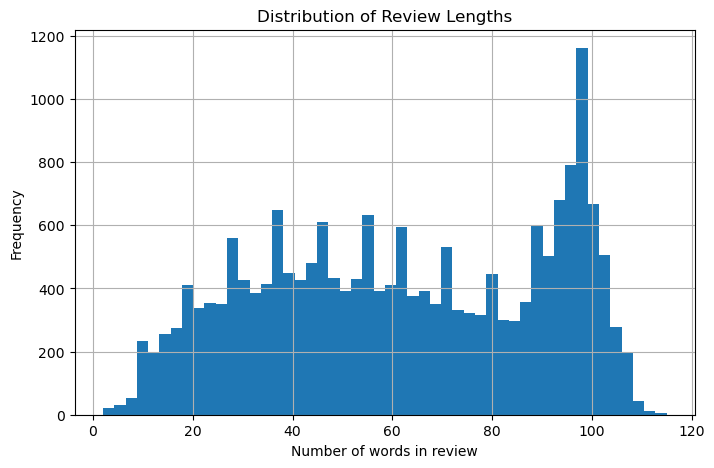

In [224]:
plt.figure(figsize=(8,5))
df["review_length"].hist(bins=50)
plt.xlabel("Number of words in review")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

The reviews range from 2 to 115 words, with an average length of about 62 words. Most fall between 40 and 90 words, and there is a clear peak around 100 words where many reviews cluster. This shows that the dataset contains mostly detailed feedback, while very short reviews are relatively uncommon.

#### 2.2.3  Most Common Words

We examine the most frequently used words in the reviews to understand the dominant themes in customer feedback. This step helps highlight common patterns, such as repeated mentions of product quality, fit, or style. It also provides insight into which terms may need to be removed later (e.g., overly common words that add little value to the model).

In [225]:
token_pattern = re.compile(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?")
all_words = []

for text in df["Review Text"].dropna():
    all_words.extend(token_pattern.findall(text.lower()))

word_counts = Counter(all_words)
word_counts.most_common(20)

[('the', 68632),
 ('i', 53272),
 ('and', 43871),
 ('a', 38469),
 ('it', 38285),
 ('is', 27497),
 ('this', 23001),
 ('to', 21865),
 ('in', 18533),
 ('but', 14738),
 ('on', 13717),
 ('for', 12499),
 ('of', 12090),
 ('with', 11485),
 ('was', 10990),
 ('so', 10670),
 ('my', 9956),
 ('dress', 9334),
 ('not', 8713),
 ('that', 8635)]

The most common words include many stopwords such as “the”, “i”, “and”, and “it”, which appear tens of thousands of times. These words occur so frequently that they contribute little to distinguishing reviews. On the other hand, some domain-specific terms, like “dress”, also appear among the top words, indicating frequent discussion of clothing items. This step confirms the need to remove stopwords while keeping relevant product-related terms for later analysis.

## 3. Natural Language Processing  

Based on the assignment requirements, we implement a preprocessing pipeline consisting of the following steps:  
1. Tokenization  
2. Lowercasing  
3. Removing short tokens (<2 characters)  
4. Removing stopwords (using the provided stop word list)  
5. Removing rare words (appearing only once across the dataset)  
6. Removing the top 20 most frequent words (based on **document** frequency)  

We first implement this baseline pipeline to ensure compliance with the requirements before making any further refinements.  

### 3.1 Tokenization  

The first step is tokenization, where we split the review text into individual words using a regular expression.  
The regex pattern `r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?"` ensures that words with hyphens or apostrophes (e.g., *well-made*, *don’t*) are treated as single tokens.

In [ ]:
# Define the regex pattern for tokenization
token_pattern = re.compile(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?")

# Apply tokenization to the Review Text column
df["tokens"] = (
    df["Review Text"]
    .astype(str)  # ensure all values are strings
    .apply(lambda text: token_pattern.findall(text))
)

# Preview the first few tokenized reviews
df[["Review Text", "tokens"]].head()

,Review Text,tokens
0,I had such high hopes for this dress and reall...,"[I, had, such, high, hopes, for, this, dress, ..."
1,"I love, love, love this jumpsuit. it's fun, fl...","[I, love, love, love, this, jumpsuit, it's, fu..."
2,This shirt is very flattering to all due to th...,"[This, shirt, is, very, flattering, to, all, d..."
3,"I love tracy reese dresses, but this one is no...","[I, love, tracy, reese, dresses, but, this, on..."
4,I aded this in my basket at hte last mintue to...,"[I, aded, this, in, my, basket, at, hte, last,..."


### 3.2 Lowercasing  

Next, we convert all tokens to lowercase to ensure consistency across the dataset.  
This prevents words like *“Dress”* and *“dress”* from being treated as separate tokens, which helps reduce redundancy and keeps the vocabulary standardized.  

In [227]:
# Convert all tokens to lowercase
df["tokens_lower"] = df["tokens"].apply(lambda tokens: [t.lower() for t in tokens])

# Preview the first few results
df[["tokens", "tokens_lower"]].head()

,tokens,tokens_lower
0,"[I, had, such, high, hopes, for, this, dress, ...","[i, had, such, high, hopes, for, this, dress, ..."
1,"[I, love, love, love, this, jumpsuit, it's, fu...","[i, love, love, love, this, jumpsuit, it's, fu..."
2,"[This, shirt, is, very, flattering, to, all, d...","[this, shirt, is, very, flattering, to, all, d..."
3,"[I, love, tracy, reese, dresses, but, this, on...","[i, love, tracy, reese, dresses, but, this, on..."
4,"[I, aded, this, in, my, basket, at, hte, last,...","[i, aded, this, in, my, basket, at, hte, last,..."


### 3.3 Removing Short Tokens  

We remove tokens with fewer than 2 characters, as these are often not meaningful words.  
This step helps eliminate noise such as stray characters or isolated letters that do not contribute useful information for analysis.  

In [228]:
# Remove tokens with length < 2
df["tokens_clean"] = df["tokens_lower"].apply(lambda tokens: [t for t in tokens if len(t) >= 2])

# Preview the cleaned tokens
df[["tokens_lower", "tokens_clean"]].head()

,tokens_lower,tokens_clean
0,"[i, had, such, high, hopes, for, this, dress, ...","[had, such, high, hopes, for, this, dress, and..."
1,"[i, love, love, love, this, jumpsuit, it's, fu...","[love, love, love, this, jumpsuit, it's, fun, ..."
2,"[this, shirt, is, very, flattering, to, all, d...","[this, shirt, is, very, flattering, to, all, d..."
3,"[i, love, tracy, reese, dresses, but, this, on...","[love, tracy, reese, dresses, but, this, one, ..."
4,"[i, aded, this, in, my, basket, at, hte, last,...","[aded, this, in, my, basket, at, hte, last, mi..."


### 3.4 Removing Stopwords  

Stopwords are common words (e.g., *the*, *and*, *is*) that occur frequently but carry little semantic value.  
We remove them using the provided stop word list to reduce noise and focus the analysis on more meaningful terms.  

In [229]:
# Remove stopwords from tokens
df["tokens_nostop"] = df["tokens_clean"].apply(lambda tokens: [t for t in tokens if t not in stopwords])

# Preview before and after removing stopwords
df[["tokens_clean", "tokens_nostop"]].head()

,tokens_clean,tokens_nostop
0,"[had, such, high, hopes, for, this, dress, and...","[high, hopes, dress, wanted, work, initially, ..."
1,"[love, love, love, this, jumpsuit, it's, fun, ...","[love, love, love, jumpsuit, fun, flirty, fabu..."
2,"[this, shirt, is, very, flattering, to, all, d...","[shirt, flattering, due, adjustable, front, ti..."
3,"[love, tracy, reese, dresses, but, this, one, ...","[love, tracy, reese, dresses, petite, feet, ta..."
4,"[aded, this, in, my, basket, at, hte, last, mi...","[aded, basket, hte, mintue, person, store, pic..."


### 3.5 Removing Rare and Frequent Words  

In this step, we refine the vocabulary by removing both extremes:  
- **Rare words** that appear only once across the dataset, as they provide little generalizable information and increase sparsity.  
- **The top 20 most frequent words** (based on document frequency), since overly common words can dominate the representation without adding meaningful context.  

This balance helps keep the vocabulary both informative and efficient for downstream modeling.  

In [ ]:
# Flatten all tokens
all_tokens = [t for tokens in df["tokens_nostop"] for t in tokens]

# Count word frequencies
freq = Counter(all_tokens)

# Identify rare words
rare_words = {word for word, count in freq.items() if count == 1}

# Identify top 20 most frequent words
doc_freq = Counter()
for tokens in df["tokens_nostop"]:
    doc_freq.update(set(tokens))  # set() avoids double-counting within the same review

top_20_words = {word for word, _ in doc_freq.most_common(20)}

# Filter out both rare and top 20 frequent words
df["tokens_final"] = df["tokens_nostop"].apply(
    lambda tokens: [t for t in tokens if t not in rare_words and t not in top_20_words]
)

# Preview before and after
df[["tokens_nostop", "tokens_final"]].head()

,tokens_nostop,tokens_final
0,"[high, hopes, dress, wanted, work, initially, ...","[high, hopes, wanted, work, initially, petite,..."
1,"[love, love, love, jumpsuit, fun, flirty, fabu...","[jumpsuit, fun, flirty, fabulous, time, compli..."
2,"[shirt, flattering, due, adjustable, front, ti...","[shirt, due, adjustable, front, tie, length, l..."
3,"[love, tracy, reese, dresses, petite, feet, ta...","[tracy, reese, dresses, petite, feet, tall, br..."
4,"[aded, basket, hte, mintue, person, store, pic...","[basket, hte, person, store, pick, teh, pale, ..."


### 3.6 Extra Processing

Although the required preprocessing steps are complete, the final preview still reveals a few issues: some words are not reduced to their base form (e.g., *hopes* → *hope*), and typos such as *hte* or *teh* remain. To further improve text quality, the next steps will introduce stemming, lemmatization, and typo correction.

#### 3.6.1 Stemming and Lemmatization  

To further normalize the text, we consider stemming and lemmatization. Stemming reduces words to their root form by chopping off endings, while lemmatization uses linguistic rules to return the base or dictionary form of a word.  

To compare the two approaches, we previewed a sample of reviews:  

- **Stemming** often produced truncated forms such as *“initi”* (from *“initially”*), *“pretti”* (from *“pretty”*), and *“outrag”* (from *“outrageously”*). While compact, these forms can be harder to interpret and may lose important meaning.  
- **Lemmatization** preserved more natural word forms, e.g., *“pretty”*, *“outrageously”*, and *“returned”*, while still reducing plurals (*“feet” → “foot”*, *“leggings” → “legging”*) and other inflections to consistent forms.  

In [231]:
# Download WordNet data if not already available
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Take a small sample of token lists to preview
sample_tokens = df["tokens_final"].head(5)

# Print original vs stemmed vs lemmatized
for i, tokens in enumerate(sample_tokens, 1):
    stems = [stemmer.stem(t) for t in tokens]
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    
    print(f"\n--- Review {i} ---")
    print("Original:   ", tokens)
    print("Stemmed:    ", stems)
    print("Lemmatized: ", lemmas)


--- Review 1 ---
Original:    ['high', 'hopes', 'wanted', 'work', 'initially', 'petite', 'usual', 'found', 'outrageously', 'fact', 'zip', 'reordered', 'petite', 'medium', 'half', 'nicely', 'bottom', 'half', 'tight', 'layer', 'cheap', 'net', 'layers', 'imo', 'major', 'design', 'flaw', 'net', 'layer', 'sewn', 'directly', 'zipper']
Stemmed:     ['high', 'hope', 'want', 'work', 'initi', 'petit', 'usual', 'found', 'outrag', 'fact', 'zip', 'reorder', 'petit', 'medium', 'half', 'nice', 'bottom', 'half', 'tight', 'layer', 'cheap', 'net', 'layer', 'imo', 'major', 'design', 'flaw', 'net', 'layer', 'sewn', 'directli', 'zipper']
Lemmatized:  ['high', 'hope', 'wanted', 'work', 'initially', 'petite', 'usual', 'found', 'outrageously', 'fact', 'zip', 'reordered', 'petite', 'medium', 'half', 'nicely', 'bottom', 'half', 'tight', 'layer', 'cheap', 'net', 'layer', 'imo', 'major', 'design', 'flaw', 'net', 'layer', 'sewn', 'directly', 'zipper']

--- Review 2 ---
Original:    ['jumpsuit', 'fun', 'flirty', '

Based on this comparison, lemmatization provides clearer, more interpretable tokens without over-simplifying. Therefore, we apply lemmatization to the final tokens to improve consistency and readability for downstream analysis.  

In [232]:
# Apply lemmatization to the final tokens
df["tokens_lemmatized"] = df["tokens_final"].apply(lambda tokens: [lemmatizer.lemmatize(t) for t in tokens])

# Preview before and after
df[["tokens_final", "tokens_lemmatized"]].head()

,tokens_final,tokens_lemmatized
0,"[high, hopes, wanted, work, initially, petite,...","[high, hope, wanted, work, initially, petite, ..."
1,"[jumpsuit, fun, flirty, fabulous, time, compli...","[jumpsuit, fun, flirty, fabulous, time, compli..."
2,"[shirt, due, adjustable, front, tie, length, l...","[shirt, due, adjustable, front, tie, length, l..."
3,"[tracy, reese, dresses, petite, feet, tall, br...","[tracy, reese, dress, petite, foot, tall, bran..."
4,"[basket, hte, person, store, pick, teh, pale, ...","[basket, hte, person, store, pick, teh, pale, ..."


#### 3.6.2 Typo Fixing  

Even after lemmatization, many reviews still contain misspellings, shorthand, or brand-specific terms. To address this, we apply a spell-checking step combined with custom whitelists and manual corrections. This ensures that genuine typos are fixed while valid domain-specific words are preserved.  

**Step 1 — Setup**  

We initialize a spellchecker and build a vocabulary from the lemmatized tokens.  
To avoid over-correcting, we automatically whitelist frequent words (≥5 occurrences) and also maintain a manual whitelist for brand names, product terms, or abbreviations.  
This provides a balance between catching real errors and respecting domain-specific vocabulary.  

In [ ]:
# Setup: spellchecker + whitelists
spell = SpellChecker()

# 1) Build a corpus vocabulary and frequencies from your lemmatized tokens
all_tokens_lemm = [t for tokens in df["tokens_lemmatized"] for t in tokens]
freq = Counter(all_tokens_lemm)

# 2) Auto-whitelist common domain words by frequency threshold (adjust if needed)
MIN_FREQ_WHITELIST = 5
auto_whitelist = {w for w, c in freq.items() if c >= MIN_FREQ_WHITELIST}

# Load frequent words into the spellchecker dictionary to avoid over-correcting domain terms
spell.word_frequency.load_words(auto_whitelist)

# 3) Manual whitelist you can edit over time (add brand names, product terms, etc.)
ignore_words = set([])

# Words you explicitly want to fix → corrected form
approved_fixes = {}

# Also load manual whitelist into the spellchecker dictionary
spell.word_frequency.load_words(ignore_words)

print(f"Initialized spellchecker. Auto-whitelisted ≥{MIN_FREQ_WHITELIST}-freq words: {len(auto_whitelist)}; manual ignore: {len(ignore_words)}")

Initialized spellchecker. Auto-whitelisted ≥5-freq words: 3804; manual ignore: 0


**Step 2 — Manual Corrections**  

Some misspellings are too context-specific for automatic tools to handle reliably.  
To improve accuracy, we maintain a dictionary of *approved fixes*, mapping common misspellings or shorthand (e.g., *"sandles" → "sandals"*) to their correct forms.  
This step also standardizes variations of the same word (e.g., *"bralettes" → "bralette"*).  

In [234]:
approved_fixes.update({
    "accomodate": "accommodate",
    "ahd": "and",
    "alittle": "little",
    "back-ordered": "backordered",
    "baby-doll": "babydoll",
    "blk": "black",                # common shorthand → color
    "bralettes": "bralette",       # aligns with your noun lemmatization
    "close-up": "closeup",
    "co-worker": "coworker",
    "curvey": "curvy",
    "cut-outs": "cutouts",
    "dissapointed": "disappointed",
    "fabri": "fabric",
    "fold-over": "foldover",
    "half-way": "halfway",
    "inbetween": "in-between",
    "blue-ish": "bluish",
    "layed": "laid",
    "bac": "back",
    "baily": "bailey",        # common name; suggestion "badly" is wrong
    "make-up": "makeup",
    "orde": "order",
    "oth": "both",
    "peite": "petite",
    "pilcro's": "pilcro",     # brand name, normalize possessive
    "retailerpolgie": "retailergologie",  # looks like misspelling of retailer + brand
    "sotre": "store",
    "stiching": "stitching",
    "sandles": "sandals",
    "wasnt": "wasn't",
    "wayyy": "way",
    "absolutley": "absolutely",
    "amterial": "material",
    "and-go": "and-go",     # but safer to normalize → "on-the-go"? (decide based on context)
    "applique": "applique", # normalize spelling without accent
    "arm-holes": "armholes",
    "atleast": "at least",  # normalize
    "balloony": "balloon",
    "becuase": "because",
    "blouse-y": "blousey",
    "buyi": "buy",
    "camisol": "camisole",
    "colo": "color",
    "colr": "color",
    "coul": "could",
    "detial": "detail",
    "dresse": "dress",
    "embroiding": "embroidering",
    "eptite": "petite",
    "fabr": "fabric",
    "high-wasted": "high-waisted",
    "hmmm": "hmm",
    "jus": "just",
    "lavendar": "lavender",
    "lenght": "length",
    "long-ish": "longish",
    "long-sleeves": "long-sleeve",
    "long-time": "longtime",
    "lov": "love",
    "middl": "middle",
    "midweight": "mid-weight",
    "muc": "much",
    "nad": "and",
    "non-existent": "nonexistent",
    "non-stop": "nonstop",
    "nto": "to",
    "orderd": "order",
    "ordere": "order",
    "over-priced": "overpriced",
    "perf": "perfect",
    "pettie": "petite",
    "pilcrow": "pilcro",
    "prett": "pretty",
    "push-up": "pushup",
    "recommen": "recommend",
    "roder": "order",
    "sandels": "sandals",
    "seater": "sweater",
    "see-though": "see-through",
    "shee": "she",
    "shir": "shirt",
    "shoul": "should",
    "skintone": "skin-tone",
    "snd": "and",
    "sti": "still",       # or "sit" if that fits context better; choose one
    "str": "star",
    "su": "so",
    "summ": "sum",
    "tee-shirt": "t-shirt",
    "throu": "through",
    "toosh": "too",       # if context is body part (toosh = tush), you might prefer ignore
    "tru": "true",        # or "try" — needs dataset context
    "tule": "tulle",      # fabric type
    "tw": "to",
    "underneat": "underneath",
    "vey": "very",
    "volumous": "voluminous",
    "waaaay": "way",
    "wais": "waist",
    "wayyyy": "way",
    "wearin": "wearing",
    "whic": "which",
    "wri": "write",
    "xtra": "extra",
    "absolutly": "absolutely",
    "accordian": "accordion",
    "ador": "adore",
    "agin": "again",
    "ahhh": "ah",
    "ahs": "as",
    "aize": "size",
    "apprx": "approx",
    "attache": "attaché",   # can also simplify to "attached"
    "beautifu": "beautiful",
    "becaus": "because",
    "bein": "being",
    "bette": "better",
    "blu": "blue",
    "bottons": "buttons",
    "boyleg": "boy-leg",    # normalize to clothing style
    "breton": "breton",          # it's actually a valid fashion term, but if you want correction → keep as-is
    "bust-line": "bustline",
    "buttoned-up": "button-up",
    "cehst": "chest",
    "chrolox": "clorox",         # likely brand typo
    "cld": "cold",               # though could also be short for "could"; context-dependent
    "clinged": "clung",          # better fix than "cringed"
    "col": "color",              # often abbreviation
    "comfotable": "comfortable",
    "comfrotable": "comfortable",
    "completel": "completely",
    "compliements": "compliments",
    "cou": "you",
    "craftmanship": "craftsmanship",
    "criss-crosses": "crisscrosses",
    "crossbody": "cross-body",   # normalize
    "crosswrap": "cross-wrap",   # normalize
    "cu": "cut",
    "cut-off": "cutoff",
    "dangly": "dangle",
    "decolletage": "décolletage",
    "definetly": "definitely",
    "defini": "define",
    "definitly": "definitely",
    "denimy": "denim",
    "did't": "didn't",
    "differen": "different",
    "disappoin": "disappoint",
    "do-able": "doable",
    "drape-y": "drapey",
    "do-over": "do-over",            # keep valid phrase, don't change to hoover
    "eit": "it",
    "ejans": "jeans",
    "eprson": "person",
    "eptites": "petites",
    "especia": "especial",
    "everthing": "everything",
    "every-day": "everyday",
    "excelle": "excellent",          # better normalization than "excelled"
    "exmaple": "example",
    "flatte": "flatter",
    "flattrering": "flattering",
    "flatttering": "flattering",
    "forwar": "forward",
    "ful": "full",
    "fuschia": "fuchsia",
    "gauzey": "gauzy",
    "gawdy": "gaudy",
    "gianormous": "ginormous",
    "giv": "give",
    "grea": "great",
    "hand-washed": "hand-wash",
    "high-waist": "high-waisted",
    "higher-waisted": "high-waisted",
    "highwaisted": "high-waisted",
    "hink": "think",
    "howeve": "however",
    "huuuge": "huge",
    "hwoever": "whoever",
    "hypen": "hyphen",
    "ike": "like",
    "isn": "isn't",
    "henleys": "henley",
    "kansa": "kansas",
    "kno": "know",
    "kne": "knee",
    "large-ish": "largish",
    "lat": "at",
    "leary": "leery",
    "legnth": "length",
    "liekd": "liked",
    "lightwei": "lightweight",
    "litt": "little",
    "littl": "little",
    "llb": "llbean",            # common brand in clothing reviews (L.L.Bean)
    "llonger": "longer",
    "lnever": "never",
    "loke": "like",
    "lon": "long",              # usually truncation
    "loompa": "oompa",          # often from “Oompa Loompa”
    "looove": "love",
    "los": "loss",              # better than “lot”
    "lotta": "lot of",
    "low-waisted": "low-waisted",
    "lucious": "luscious",
    "luv": "love",
    "lvoe": "love",
    "lwait": "wait",
    "mateiral": "material",
    "materia": "material",
    "materiel": "material",
    "mauve-ish": "mauvish",
    "mentioend": "mentioned",
    "metalic": "metallic",
    "mid-riff": "midriff",
    "midrise": "mid-rise",
    "mary": "mary",             # keep as name, but if context shows typo of “many” → map to "many"
    "marroon": "maroon",
    "marilyn": "marilyn",       # valid name (keep unless you want to normalize to “marlin”)
    "martie": "martie",         # name, but if typo → "martin"
    "mexican": "mexican",       # nationality, keep as-is
    "multi-colored": "multicolored",
    "neede": "need",
    "nicel": "nice",
    "non-issue": "nonissue",
    "non-traditional": "nontraditional",
    "noticable": "noticeable",
    "offwhite": "off-white",   # if you prefer to normalize; otherwise keep in ignore_words
    "one-size": "one-size",    # keep as sizing token; do NOT change to "oversize"
    "onsie": "onesie",
    "othe": "the",
    "ou": "you",
    "ov": "of",
    "over-dress": "overdress",
    "over-lay": "overlay",
    "pai": "pay",
    "peice": "piece",
    "perfe": "perfect",
    "perhap": "perhaps",
    "petities": "petites",
    "petitte": "petite",
    "pilcos": "pilco",
    "pictur": "picture",
    "lyocel": "lyocell",
    "lucious": "luscious",     # if not already added earlier
    "plasticy": "plasticky",     # more natural than "plastic" for texture
    "pool-side": "poolside",
    "popback": "pop-back",
    "post-partum": "postpartum",
    "potatoe": "potato",
    "prefectly": "perfectly",
    "re-ordering": "reordering",
    "re-stock": "restock",
    "reall": "really",
    "recomend": "recommend",
    "rediculously": "ridiculously",
    "referance": "reference",
    "regulat": "regular",
    "retuned": "returned",
    "righ": "right",
    "risqu": "risqué",
    "seea": "see",
    "shap": "shape",
    "shld": "should",
    "petities": "petites",
    "petitte": "petite",
    "pictur": "picture",
    "pilcos": "pilco",
    "purcha": "purchase",
    "purc": "purchase",
    "quali": "quality",
    # keep earlier decisions consistent:
    "over-dress": "overdress",
    "over-lay": "overlay",
    "recomme": "recommend",
    "shou": "show",
    "show-stopper": "showstopper",
    "sie": "she",
    "silouette": "silhouette",
    "size-i": "size",
    "sizi": "size",
    "sleevless": "sleeveless",
    "slighly": "slightly",
    "slighty": "slightly",
    "smaill": "small",
    "sofisticated": "sophisticated",
    "stretc": "stretch",
    "styl": "style",
    "summe": "summer",
    "sweater-coat": "sweatercoat",   # if you prefer preserving hyphen, move to ignore_words instead
    "t'shirt": "t-shirt",
    "taupey": "taupe",
    "taylored": "tailored",
    "tey": "they",
    "th": "the",
    "thes": "the",
    "thier": "their",
    "thin-ish": "thinnish",
    "thre": "the",
    "throw-away": "throwaway",
    "thsi": "this",
    "tight-fitting": "tightfitting",
    "tme": "the",
    "toget": "get",
    "togethers": "together",
    # keep “too-small” as a valid descriptor (see ignore below)
    "tyhlo": "typo",
    "un-button": "unbutton",
    "unflatering": "unflattering",
    "unfortunatly": "unfortunately",
    "uppe": "upper",
    "undernea": "underneath",   # align with earlier “underneat” → “underneath”
    "waht": "what",
    "warm-up": "warmup",
    "week-end": "weekend",
    "wel": "we",
    "wiast": "waist",
    "xlarge": "large",
    "xxsmall": "x-small",
    "youre": "your",
    "unfort": "unfortunately",   # common truncation in reviews
})

Some terms are too ambiguous to contribute meaningful insights.
To avoid noise, we maintain a list of ignored words that may represent names, acronyms, or brands (e.g., "ada", "alaska") and are therefore excluded from analysis.

In [235]:
ignore_words.update([
    "ada",            # could be name/acronym/brand
    "alaska",
    "as-is",
    "atlanta",
    "ankle-length",
    "american",
    "basketweave",
    "bermuda",
    "birkenstocks",
    "blue-green",
    "boatneck",
    "body-hugging",
    "body-skimming",
    "boston",
    "charlie's",
    "cowlneck",
    "criss",          # often from "criss-cross"
    "d's",            # bra sizing context possible
    "da",             # dialect/name; avoid auto-fix
    "day-to",         # likely part of "day-to-day"
    "dddd",           # sizing shorthand (e.g., DDD)
    "drop-waist",
    "flip-flop",
    "gauze-like",
    "handwash",
    "high-end",
    "honolulu",
    "hoxton",         # style/brand/cut
    "in-between",     # already normalized target exists
    "less-than",
    "april",            # month
    "levi's",           # brand
    "lola",             # name
    "lyocell",          # fabric
    "machine-washable", 
    "marrakech",        # place
    "medium-weight", 
    "miami",            # place
    "mid-knee", 
    "mih",              # brand (MIH Jeans)
    "mockneck",         # clothing style
    "neira",            # name
    "no-brainer",
    "no-go",            # valid slang
    "off-center",
    "oop",              # could be slang ("out of print", "oops")
    "post-pregnancy",
    "rosie",            # name
    "s-m",              # size
    "sacklike", 
    "se",               # abbreviation (Southeast, Spanish "se")
    "shapewear", 
    "sl",               # abbreviation
    "small-medium",     # size
    "socal",            # region
    "super-flattering", 
    "tentlike", 
    "tie-dye", 
    "tie-neck", 
    "uk",               # country
    "und",              # German word for "and"
    "underslip", 
    "v-cut", 
    "v-shape", 
    "vee",              # neckline type
    "verdugo",           # denim brand
    "pd",                # abbreviation
    "well-done",
    "well-endowed",
    "well-fitting",      # correction to "ill-fitting" is wrong
    "xmas",              # common short form
    "abo",               # could be abbreviation
    "above-the", 
    "activewear",
    "age-appropriate",
    "air-dried",
    "alexandria",        # place
    "amadi",             # brand/name
    "amalfi",            # place
    "anth",              # shorthand for Anthropologie
    "app",               # app (application)
    "aren",              # could be "aren’t", leave as context check
    "as-pictured",
    "asia",
    "athleisure",
    "bam",               # slang
    "bbq",               # abbreviation
    "bday",              # short for birthday
    "beca",              # name
    "becau",             # likely cut-off typing, but too ambiguous
    "betty",             # name
    "bl",                # abbreviation (black, blouse, etc.)
    "black-and",         # part of compound "black-and-white"
    "bling",             # slang
    "body-type",
    "boho-chic",
    "bootcut",
    "bot",               # slang/chat context
    "british",
    "business-casual",
    "cafe",
    "cami's",            # possessive
    "cardio",
    "carissima",         # Italian word/name
    "chanel",             # brand
    "clo",                 # could be CLO unit/abbr; ambiguous
    "color-wise",
    "colorblock",
    "crewneck",
    "cupro",               # fabric
    "dallas",
    "dara",                # name
    "defin",               # likely truncated “definitely”; avoid wrong fix
    "delicates",           # valid laundry term
    "diego",
    "dn",                  # abbreviation
    "double-layered",
    "double-sided",
    "downton",             # could be “Downton”
    "dre",                 # truncated; ambiguous
    "dryel",               # brand (home dry-cleaning)
    "dy",                  # ambiguous
    "easy-to",
    "evanthe",             # name/brand
    "ever-so",
    "faux-fur",
    "feb",                 # month abbr
    "fiance",              # valid word (don’t change to finance)
    "fr", "ge", "gr", "gre",   # ambiguous short tokens
    "grecian",
    "hh",
    "hollywood",
    "ia", "ibs",           # abbreviations
    "irish",
    "january",
    "kate",
    "ke", "keds", "kn",
    "maternity-like",
    "mid-hip",
    "midwest",
    "missoni",        # brand
    "mona",           # name
    "monday",         # weekday
    "mumu",           # garment style
    "no-fuss",
    "non-stretchy",
    "nouveau",
    "nye",            # New Year's Eve
    "onesie",
    "op",             # abbreviation
    "orleans",        # place
    "over-shirt",     # fashion term; if you prefer, later normalize -> "overshirt"
    "paquerette",     # name/line
    "pepto",          # brand
    "polka-dots",
    "prima",          # valid word
    "pur",            # ambiguous abbrev/brand
    "raf",            # acronym
    "ranna",          # designer (Ranna Gill)
    "rec",            # abbreviation (recommend/receipt/record)
    "red-orange",
    "sc",             # abbreviation (e.g., South Carolina)
    "seasonless",
    "self-conscious",
    "sewn-in",
    "shearling",       # valid fabric
    "short-sleeved",
    "show-through",
    "size-wise",
    "skin-toned",
    "skorts",          # valid clothing type
    "sle",             # ambiguous abbreviation
    "small-framed",
    "super-sale",
    "swea",            # truncation, risky
    "t-back",          # lingerie style
    "top-heavy",       # valid descriptor
    "tucked-in",       # style term
    "umph",            # interjection
    "uncuff",          # style term
    "ur",              # abbreviation for “your”
    "velcro",          # brand
    "washed-out",
    "well-worn",
    "whi",             # truncation, ambiguous
    "win-win",
    "wishlist",
    "woolite",         # brand
    "two-tone",       # valid style term
    "x-large", "x-s", "xl's", "xxxl",   # sizing
    "a-cup",          # bra size
    "a-flutter",      # valid expression
    "a-frame",        # style/structure
    "a-kind",         # phrase
    "a-symmetric",    # variant of asymmetric
    "abby",           # name
    "abou",           # truncated "about", but risky
    "add-on",         # common term
    "ag's",           # abbreviation
    "all-around",
    "all-in",
    "all-over",
    "allison",        # name
    "amd",            # typo for "and", but also common abbrev (Advanced Micro Devices)
    "angeles",        # Los Angeles
    "ann's",          # possessive
    "apple-shaped",   # body description
    "arielle",        # name
    "arty-looking",   # valid descriptor
    "ashley",         # name
    "atl",            # abbreviation for Atlanta
    "az",             # abbreviation for Arizona
    "b-c", "ba",      # ambiguous abbrevs
    "back-up",        # valid expression
    "bea",            # name
    "bec",            # abbreviation
    "bell-sleeve",    # clothing style
    "bf", "bff",      # slang
    "blue-grey",      # color
    "bluishgreen",    # color
    "boat-neck",      # clothing style
    "bodytype",       # descriptor
    "bomber-style",   # clothing style
    "bottom-heavy",   # descriptor
    "bra-straps",     # clothing
    "broad-shouldered",
    "brooklyn",       # place
    "btu",            # abbreviation (British Thermal Unit)
    "bubble-like",
    "button-front",
    "c-cup", "c-d",   # bra sizes
    "cali",           # short for California
    "canvas-y",       # fashion descriptor
    "cardis",         # shorthand for cardigans
    "casu",           # shorthand for casual
    "cc",             # abbreviation
    "charleston",     # place
    "children's",
    "coh's",          # could be brand/possessive
    "color-blocking", "colorblocked", "colorwise", "coloured", # fashion terms / accepted spellings
    "corodorys",      # might be variant misspelling of corduroys; if frequent, consider adding fix
    "denver",         # place
    "dept",           # abbreviation for department
    "desi",           # proper noun / cultural term
    "dolman-style",   # clothing type
    "double-lined",
    "double-v",
    "druzy",          # gem term
    "dry-clean", "dry-cleaning", # valid clothing care instructions
    "dryclean",          # garment care term
    "durham",            # place name
    "earth-tone",        # valid descriptor
    "easy-breezy",       # valid phrase
    "eira",              # name
    "eloise",            # name
    "else's",            # valid possessive
    "emb",               # abbreviation
    "endora",            # name
    "erin",              # name
    "errand-running",    # phrase
    "eu",                # abbrev/region
    "everleigh",         # name/brand
    "ewww",              # expression
    "extra-large",       # sizing
    "fairisle",          # knitting style
    "fall-winter",       # fashion season
    "farrah",            # name
    "favourite",         # valid British spelling
    "february",          # month
    "felty",             # texture term
    "femine",            # ambiguous, could be mistaken spelling but not common enough
    "feminie",           # same, could map → feminine, but might distort rare text
    "fetherston",        # designer (Erin Fetherston)
    "ff",                # abbreviation
    "fianc",             # possibly truncation of fiancé; safer to ignore
    "figure-hugging",    # style term
    "filipino",          # nationality, valid
    "fit-wise",          # valid descriptor
    "five-year",         # phrase
    "fla",               # abbreviation/slang
    "fleetwood",         # name
    "flesh-colored",     # valid descriptor
    "flirtiness",        # valid word
    "flo",               # name/slang
    "flowier",           # valid comparative
    "foldover",          # style term
    "form-fitted",       # valid fashion descriptor
    "france",            # place
    "full-time",         # phrase
    "fully-lined",       # descriptor
    "g's",               # slang
    "ga",                # abbreviation/state
    "expe",              # ambiguous truncation (expect/expense/experience)
    "georgette",         # fabric
    "go-anywhere",       # valid phrase
    "greek",             # valid nationality/descriptor
    "hahaha",            # expression
    "hand-knit",         # descriptor
    "haute",             # fashion term
    "hei-hei",           # brand (Anthropologie)
    "high-heeled",       # descriptor
    "hipline",           # garment measurement term
    "hol",               # ambiguous truncation (holiday/hold)
    "hook-and",          # part of "hook-and-eye/loop"
    "housedress",        # garment
    "hr",                # abbreviation (hour/human resources)
    "inbox",             # valid word
    "iphone",            # product
    "isabella",          # name
    "italian",           # nationality
    "itty",              # valid word
    "jackie", "japanese", "jeera", "joan", "joe's",  # names/valid words
    "jammie",            # colloquial (pajamas)
    "ju", "juuuust",     # stylized emphasis
    "kedia",             # uncertain; leave as-is
    "kentucky", "kim",   # proper nouns
    "l-xl",              # size token
    "lace-like",         # descriptor
    "levi",              # brand
    "jewel-tone",        # valid fashion term
    "knit-like",         # valid descriptor
    "light-colored",
    "light-to",
    "little-girl",
    "looooooove",        # stylized
    "loose-fit",         # descriptor
    "louisiana",         # place
    "maternity-esque",   # style descriptor
    "mcguire",           # brand
    "meda",              # possible name
    "mediterranean",     # region
    "medium-to",         # descriptor
    "mid-length",
    "mid-september",
    "mid-shin",
    "midi-length",
    "minneapolis",       # place
    "mismarked",         # valid term
    "mixed-media",       # descriptor
    "mmmmm",             # stylized
    "mn",                # abbreviation
    "mock-neck",         # descriptor
    "lin",                  # could be name (Lin)
    "london",               # place
    "lycra",                # fabric
    "might've",             # valid contraction
    "min",                  # ambiguous (minute/minimum)
    "mini-dress",           # style term
    "mom-bod",              # descriptor
    "monica",               # name
    "moo-moo",              # variant of muumuu; keep as written
    "muffin-top",           # descriptor
    "mui",                  # ambiguous (brand/abbr)
    "must-buy",             # phrase
    "napa",                 # place
    "newport",              # place/brand
    "non-bulky", "non-flattering", "non-maternity",  # descriptive hyphen forms
    "nordstrom",            # store/brand
    "not-too",              # phrase (often part of compound)
    "november",             # month
    "nude-colored",         # descriptor
    "ny",                   # New York abbrev
    "off-shoulder",         # style term
    # If you chose to normalize offwhite above, remove it from ignore_words; else keep it here:
    # "offwhite",
    "one-of",               # phrase
    "ons",                  # ambiguous abbrev
    "oompa",                # part of “Oompa Loompa”
    "open-weave",           # descriptor
    "orange-y", "orangish", # color descriptors
    "otk",                  # over-the-knee (boots)
    "overnighted",          # valid past tense verb
    "pajama-like",          # descriptor
    "pants-they",           # punctuation artifact; safest to leave
    "petite-sized",         # descriptor
    "photoshoot", "photoshopped",
    "pilly",                # real adjective (fabric pilling)
    "pintucks",
    "pippa",                 # name
    "pkg",                   # abbreviation (package)
    "polka-dot", "polkadots",
    "poncho-like", "poncho-type",
    "poofiness",             # valid word in fashion context
    "pop-back",              # product/style term in some listings
    "pre-baby", "pre-ordered", "pre-washed", "pre-wedding",  # valid “pre-” forms
    "preggers", "preggo", "prego",  # slang; keep if you want to preserve tone
    "pricepoint",            # common retail term
    "proba", "produ",        # ambiguous truncations
    "provence",              # place
    "recd",                  # “rec’d” / received abbrev
    "regular-length", "relaxed-fit",
    "reno",                  # place
    "retu",                  # ambiguous truncation
    "ri", "rica",            # could be RI (state)/Costa Rica
    "rockefeller",           # proper noun
    "roll-up",               # style term
    "rona",                  # name
    "rosey",                 # earlier you mapped to “rose”; if you prefer adjective, use “rosy” in approved_fixes
    "ru",                    # if earlier mapped to "run", remove from ignore to avoid conflict
    "sale-on",               # phrase
    "scotty",                # name
    "semi-fitted",
    "sf",                    # abbreviation
    "shearling-lined",
    "shooties",             # legit shoe/bootie style
    "side-zipper",          # style/feature term
    "sinclair",             # proper noun
    "sister-in",            # compound (often part of “sister-in-law”)
    "siyu",                 # name/brand
    "sk",                   # abbreviation
    "skir",                 # ambiguous truncation (could be “skirt”)
    "slee",                 # ambiguous truncation
    "sli", "slig",          # ambiguous truncations
    "slubby",               # legitimate fabric texture
    "small-ish",            # accepted hyphenated form
    "soft-looking",
    "sooooooo",             # stylized emphasis
    "souers",               # ambiguous (name/typo); safer to keep
    "special-occasion",
    "spetite",              # if you intended to normalize → move to approved_fixes = "petite"
    "spokane",              # place
    "square-apple",         # body-shape descriptor
    "stand-out",            # descriptor (earlier kept)
    "starbucks",            # brand
    "static-y",             # keep as written for consistency (you can normalize → “staticky” if desired)
    "stra",                 # ambiguous truncation (star/strap/straight)
    "straight-leg", "straight-legged",
    "super-hot", "super-skinny", "super-tiny",
    "sur", "sw",            # abbreviations
    "tailor-fitted",
    "tennies",              # slang for sneakers
    "tenty",                # legit adjective meaning “tent-like”
    "terrycloth-like",
    "tex",                  # abbreviation
    "that'd", "that'll",    # valid contractions (don’t change to “that’s”)
    "ther",                 # ambiguous (the/there/their) — safer to leave
    "size-small",          # size descriptor
    "too-small",           # valid descriptor
    "torsoed",             # fashion/silhouette term; suggestion “tossed” is wrong
    "tuesday",             # weekday
    "tunic-like",          # descriptor
    "tx",                  # abbreviation (Texas, transaction, etc.)
    "unco",                # ambiguous truncation
    "uncuffed",            # style term
    "under-slip",          # garment term; suggestion is wrong
    "unseamed",            # valid adjective
    "unstitched",          # valid adjective
    "upside-down",         # descriptor
    "upsize", "upsizing",  # valid retail terms
    "usu",                 # abbreviation for “usually”
    "v's",                 # pluralized letter/size notation
    "v-neckline",          # descriptor
    "versat",              # ambiguous truncation (could be versatile/versatility)
    "vinyasa",             # yoga style
    "wamp",                # ambiguous (name/slang)
    "washability",         # descriptor
    "wedding-ish",         # descriptor
    "well-cut",            # descriptor
    "workwear",            # valid term
    "worn-in",             # descriptor
    "wrinkle-prone",       # descriptor
    "xs's",                # size/plural form
    "xxl",                 # size
    "zag",                 # valid word (as in zig-zag)
    "tra",                # ambiguous truncation (try/track/trapeze) — safer to keep
    "vintage-looking",    # valid descriptor
    "wid",                # ambiguous (with/would) — you previously kept this; stay consistent
])


**Step 3 — Candidate Review**  

With the whitelist and corrections in place, we re-check the vocabulary to find remaining unknown words.  
The spellchecker suggests corrections, which we review manually before deciding whether to fix, ignore, or whitelist.  
This iterative process helps us refine the dictionary while preventing false corrections.  

In [ ]:
TOP_N = 60  # how many to preview

# Exclude known-safe words and anything you already plan to auto-fix
candidate_vocab = set(all_tokens_lemm) - ignore_words - set(approved_fixes)

# Let pyspellchecker tell us what's unknown
misspelled = spell.unknown(candidate_vocab)

if not misspelled:
    print("No remaining candidate misspellings (after ignores/fixes).")
else:
    review_df = (
        pd.DataFrame({"word": sorted(misspelled)})
          .assign(
              freq=lambda d: d["word"].map(freq.get),
              suggestion=lambda d: d["word"].map(spell.correction),
          )
          .sort_values(["freq", "word"], ascending=[False, True])
          .reset_index(drop=True)
    )
    from IPython.display import display
    display(review_df.head(TOP_N))
    print(f"Found {len(review_df)} candidate misspellings (excluding ignores/fixes).")

No remaining candidate misspellings (after ignores/fixes).


**Step 4 — Apply Fixes**  

Finally, we apply the typo-fixing function to each review.  
This function checks each token against the whitelists and correction dictionary:  
- If it belongs to the ignore list, it is preserved as-is.  
- If it has a manual correction, it is replaced accordingly.  
- Otherwise, the spellchecker suggests a fix only if the token is flagged as misspelled.  

The result is a new column `tokens_typo_fixed` with cleaner, standardized tokens suitable for modeling.  

In [237]:
def apply_typo_fixes(tokens, spell, approved_fixes, ignore_words):
    fixed = []
    for t in tokens:
        if t in ignore_words:
            fixed.append(t)
        elif t in approved_fixes:
            fixed.append(approved_fixes[t])
        else:
            # optional: only auto-correct if it's in spell.unknown
            if t in spell.unknown([t]):
                suggestion = spell.correction(t)
                fixed.append(suggestion if suggestion else t)
            else:
                fixed.append(t)
    return fixed

# Apply to all rows
df["tokens_typo_fixed"] = df["tokens_lemmatized"].apply(
    lambda toks: apply_typo_fixes(toks, spell, approved_fixes, ignore_words)
)

### 3.7 Null Values Check  

As a final step, we check the dataset for missing values.  
During preprocessing, some reviews may have had all their tokens removed (for example, if every word was filtered out).  
This would leave empty token lists, which need to be identified and handled to ensure the dataset remains consistent for modeling.  

In [ ]:
# List of token columns to check
token_cols = [
    "tokens_final",
    "tokens_lemmatized",
    "tokens_typo_fixed"
]

# Check empties column by column
empty_mask = pd.DataFrame({
    col: df[col].apply(lambda x: len(x) == 0 if isinstance(x, list) else True)
    for col in token_cols
}).any(axis=1)

empty_rows = df[empty_mask]

if empty_rows.empty:
    print("All rows contain at least one token in every token column.")
else:
    print(f"Found {len(empty_rows)} rows with empty token lists in one or more columns.")
    for col in token_cols:
        n_empty = empty_rows[col].apply(lambda x: len(x) == 0 if isinstance(x, list) else False).sum()
        if n_empty > 0:
            print(f" - {col}: {n_empty} empty rows")
    display(empty_rows[["Review Text"] + token_cols].head(10))

Found 10 rows with empty token lists in one or more columns.
 - tokens_final: 10 empty rows
 - tokens_lemmatized: 10 empty rows
 - tokens_typo_fixed: 10 empty rows


,Review Text,tokens_final,tokens_lemmatized,tokens_typo_fixed
4160,I would have liked it but it was too small for...,[],[],[]
6521,Great fit,[],[],[]
11211,Fits perfect!,[],[],[]
11568,Love this dress and the color,[],[],[]
12662,So soft and comfortable!,[],[],[]
12777,"Fits great, comfortable!",[],[],[]
13095,Fits perfect.,[],[],[]
14727,So comfortable-so versatile-so perfect,[],[],[]
15314,"Very comfortable to wear, love the overall loo...",[],[],[]
18113,"Fits well, soft and comfortable",[],[],[]


The check shows that 10 reviews ended up with empty token lists across all processing stages.  
These cases typically occur when very short reviews lose all of their words during cleaning (e.g., after stopword removal or typo correction).  
Since they no longer contain meaningful content, we will remove these rows to maintain a clean dataset.  

In [239]:
# Remove rows with empty tokens in any of the tracked columns
df = df[~empty_mask].copy()

print(f"Cleaned dataset: {df.shape[0]} rows remain after removing {empty_mask.sum()} empty rows.")

Cleaned dataset: 19652 rows remain after removing 10 empty rows.


After removing the empty rows, the dataset now contains only reviews with valid tokens.  
This ensures that every remaining record contributes useful information for feature extraction and modeling.

## 4. Save the Cleaned Data  

After completing the preprocessing pipeline, we now save the cleaned results.  
This ensures that the processed text and vocabulary can be reused later for feature extraction and model building, without having to rerun all earlier steps.

### 4.1 Save the Processed Text  

We first keep only the final tokenized form (`tokens_typo_fixed`) and drop intermediate columns used during preprocessing.  
The tokens are stored in a new column `processed_tokens`, and we also create a joined string version (`processed_text`) for easier inspection.  

Finally, we save the processed text into `processed.csv`, which contains one cleaned review per row.  
This file will serve as the input for subsequent tasks.  

In [ ]:
# 1) Keep only final tokens
token_cols_to_drop = [
    "tokens", "tokens_lower", "tokens_clean", "tokens_nostop",
    "tokens_final", "tokens_lemmatized"
]
existing_drop = [c for c in token_cols_to_drop if c in df.columns]
df = df.drop(columns=existing_drop)

# Make a clearly named final column
df["processed_tokens"] = df["tokens_typo_fixed"]
df = df.drop(columns=["tokens_typo_fixed"])

# Create a single string per review for saving/inspection
df["processed_text"] = df["processed_tokens"].apply(lambda toks: " ".join(toks))

# Save processed.csv
df.to_csv("../output/processed.csv", index=False)
print("Saved processed.csv with processed_text column.")

Saved processed.csv with processed_text column.


### 4.2 Save the Vocabulary  

Next, we build the vocabulary from the processed tokens.  
The vocabulary is sorted alphabetically, and each word is assigned an index starting at 0.  
This ensures consistency in later vectorization steps, where tokens must be mapped to fixed indices.  

The vocabulary is saved to `vocab.txt` in the required format (`word:index`), providing a clean reference for interpreting feature representations.

In [ ]:
# Flatten all tokens from the final processed column
all_tokens = [t for toks in df["processed_tokens"] for t in toks]

# Build vocabulary 
vocab = sorted(set(all_tokens))  # alphabetical

# Write vocab.txt as `word:index` starting at 0
with open("../output/vocab.txt", "w", encoding="utf-8") as f:
    for idx, word in enumerate(vocab):
        f.write(f"{word}:{idx}\n")

print(f"Saved vocab.txt with {len(vocab)} entries (alphabetical, 0-based).")

Saved vocab.txt with 6548 entries (alphabetical, 0-based).


## Summary 

In this task, we built a complete preprocessing pipeline for customer clothing reviews.  
We standardized tokens through lowercasing, lemmatization, and typo fixing, while removing noisy elements such as stopwords, rare words, and overly frequent terms.  
We also ensured data integrity by handling empty reviews and finally produced two essential outputs:  
- **processed.csv**, containing the cleaned text.  
- **vocab.txt**, containing the finalized vocabulary in the required format.  

Through this process, we learned that even seemingly simple preprocessing requires careful design:  
- Too much filtering risks removing meaningful reviews.  
- Stemming can distort words, while lemmatization preserves more natural forms.  
- Spellchecking requires a balance of automation and manual oversight to avoid mis-corrections.  

Overall, this task highlights the importance of systematic text cleaning in preparing data for NLP models.  
The cleaned dataset and vocabulary now form a strong foundation for the next stages of feature extraction and classification.  